# Parameters

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
source_folder = '/content/gdrive/My Drive/nlp_BCN/ratings.csv'
destination_folder = '/content/gdrive/My Drive/nlp_BCN/model'

# Libraries

In [3]:
!pip install transformers

     |████████████████████████████████| 1.3MB 3.5MB/s 
     |████████████████████████████████| 890kB 22.4MB/s 
     |████████████████████████████████| 1.1MB 26.6MB/s 
     |████████████████████████████████| 2.9MB 37.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a899a23b4651828a7093ff148fd4936d9ea718d6cac95319f4bfc4da24fb2a36
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim
from tqdm import tqdm

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [5]:
data = pd.read_csv(source_folder)
data['RATING'] = data['RATING'] -1 #So that we have labels between 0 and 4 

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Preliminaries

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
# Model parameter
MAX_SEQ_LEN = 200 
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

RATING = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
TEXT = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('TEXT', TEXT), ('RATING', RATING)]

# TabularDataset
dataset = TabularDataset(path=source_folder,format='CSV', skip_header=True,fields=[('TEXT',TEXT),('RATING',RATING)])
trainset, valset, testset = dataset.split([0.7,0.15,0.15], stratified=True, strata_field='RATING')

# Iterators
train_iter, valid_iter, test_iter = BucketIterator.splits((trainset, valset, testset), batch_size=100,
                                                          sort_key=lambda x: len(x.TEXT),repeat=False, shuffle=True, device=device)


# Model

In [9]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name, num_labels = 6)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [10]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in tqdm(train_loader):
            labels = labels.type(torch.LongTensor)     
            labels = labels.to(device)
            output = model(text,labels)
            loss, _ = output


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        output = model(text,labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()
                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/10], Step [35/700], Train Loss: 1.6823, Valid Loss: 1.6058


 50%|█████     | 35/70 [09:31<18:56, 32.46s/it]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 99%|█████████▊| 69/70 [24:19<00:32, 32.17s/it]

Epoch [1/10], Step [70/700], Train Loss: 1.5762, Valid Loss: 1.4558


  0%|          | 0/70 [00:00<?, ?it/s]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 49%|████▊     | 34/70 [16:49<17:42, 29.52s/it]

Epoch [2/10], Step [105/700], Train Loss: 1.3126, Valid Loss: 1.1894


 50%|█████     | 35/70 [18:49<33:02, 56.65s/it]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 99%|█████████▊| 69/70 [27:19<00:14, 14.87s/it]

Epoch [2/10], Step [140/700], Train Loss: 1.0589, Valid Loss: 0.9297


  0%|          | 0/70 [00:00<?, ?it/s]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 49%|████▊     | 34/70 [08:19<08:47, 14.65s/it]

Epoch [3/10], Step [175/700], Train Loss: 0.7923, Valid Loss: 0.8473


 50%|█████     | 35/70 [09:34<19:01, 32.62s/it]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 99%|█████████▊| 69/70 [17:51<00:14, 14.59s/it]

Epoch [3/10], Step [210/700], Train Loss: 0.7145, Valid Loss: 0.7141
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt


  0%|          | 0/70 [00:00<?, ?it/s]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 49%|████▊     | 34/70 [08:17<08:47, 14.65s/it]

Epoch [4/10], Step [245/700], Train Loss: 0.5014, Valid Loss: 0.5460


 50%|█████     | 35/70 [09:31<18:56, 32.48s/it]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 99%|█████████▊| 69/70 [17:47<00:14, 14.55s/it]

Epoch [4/10], Step [280/700], Train Loss: 0.3983, Valid Loss: 0.4466


  0%|          | 0/70 [00:00<?, ?it/s]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 50%|█████     | 35/70 [10:11<20:34, 35.26s/it]

Epoch [5/10], Step [315/700], Train Loss: 0.2773, Valid Loss: 0.4820


 99%|█████████▊| 69/70 [19:06<00:15, 15.68s/it]

Epoch [5/10], Step [350/700], Train Loss: 0.2262, Valid Loss: 0.3947


  0%|          | 0/70 [00:00<?, ?it/s]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 49%|████▊     | 34/70 [08:41<08:44, 14.56s/it]

Epoch [6/10], Step [385/700], Train Loss: 0.1675, Valid Loss: 0.3633


 50%|█████     | 35/70 [09:55<18:51, 32.33s/it]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 99%|█████████▊| 69/70 [18:11<00:14, 14.62s/it]

Epoch [6/10], Step [420/700], Train Loss: 0.1639, Valid Loss: 0.3566


  0%|          | 0/70 [00:00<?, ?it/s]

Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/model.pt
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


 50%|█████     | 35/70 [09:33<19:16, 33.04s/it]

Epoch [7/10], Step [455/700], Train Loss: 0.1207, Valid Loss: 0.3632


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [7/10], Step [490/700], Train Loss: 0.1246, Valid Loss: 0.3734


 50%|█████     | 35/70 [15:42<40:26, 69.31s/it]

Epoch [8/10], Step [525/700], Train Loss: 0.0871, Valid Loss: 0.3724


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [8/10], Step [560/700], Train Loss: 0.0723, Valid Loss: 0.3795


 50%|█████     | 35/70 [10:58<19:24, 33.26s/it]

Epoch [9/10], Step [595/700], Train Loss: 0.0486, Valid Loss: 0.3821


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [9/10], Step [630/700], Train Loss: 0.0696, Valid Loss: 0.3991


 50%|█████     | 35/70 [11:45<23:57, 41.08s/it]

Epoch [10/10], Step [665/700], Train Loss: 0.0467, Valid Loss: 0.3904


100%|██████████| 70/70 [22:15<00:00, 19.07s/it]

Epoch [10/10], Step [700/700], Train Loss: 0.0575, Valid Loss: 0.3909
Model saved to ==> /content/gdrive/My Drive/nlp_BCN/model/metrics.pt
Finished Training!


Model loaded from <== /content/gdrive/My Drive/nlp_BCN/model/metrics.pt


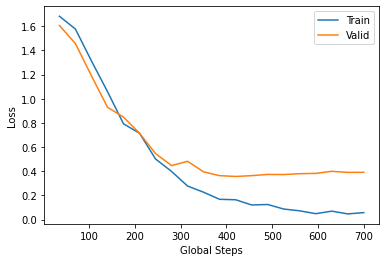

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [11]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:') 
    print(classification_report(y_true, y_pred, target_names = ['RATING 1', 'RATING 2', 'RATING 3', 'RATING 4', 'RATING 5'], digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['1', '2','3', '4','5'])
    ax.yaxis.set_ticklabels(['1', '2','3', '4','5'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/nlp_BCN/model/model.pt
Classification Report:
              precision    recall  f1-score   support

    RATING 1     0.9786    0.9464    0.9622      1400
    RATING 2     0.9259    0.9721    0.9484      1400
    RATING 3     0.9708    0.9500    0.9603      1400
    RATING 4     0.9514    0.9507    0.9511      1400
    RATING 5     0.9751    0.9800    0.9776      1400

    accuracy                         0.9599      7000
   macro avg     0.9604    0.9599    0.9599      7000
weighted avg     0.9604    0.9599    0.9599      7000



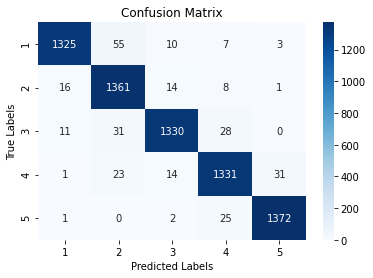

In [13]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, train_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/nlp_BCN/model/model.pt
Classification Report:
              precision    recall  f1-score   support

    RATING 1     0.9858    0.9267    0.9553       300
    RATING 2     0.9102    0.9800    0.9438       300
    RATING 3     0.9505    0.9600    0.9552       300
    RATING 4     0.9593    0.9433    0.9513       300
    RATING 5     0.9832    0.9733    0.9782       300

    accuracy                         0.9567      1500
   macro avg     0.9578    0.9567    0.9568      1500
weighted avg     0.9578    0.9567    0.9568      1500



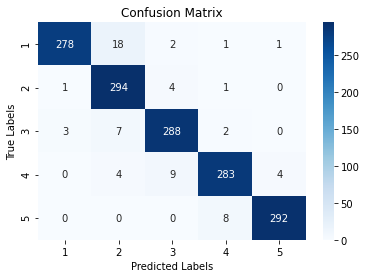

In [12]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)